<img src="usi_inf_logo.png" style="width: 400px; padding-left: 50px; padding-top: 20px;" align="right"/>


# Project 8- High-Performance Computing in Jupyter

## Student Name, Date

# Example of a simple NLP problem solved with IPOPT

Minimize $ f(x) := \left( x_0 \cdot x_3  \cdot \sum_{i=0}^2 x_i \right) + x_2$

subject to 

$\qquad x^T x = 40$

$\qquad \prod_{i=0}^3 x_i \geq 25$

$\qquad 1 \leq x \leq 5$

In [1]:
from __future__ import print_function, unicode_literals

import sys
import cyipopt
import numpy as np
import matplotlib.pyplot as plt

We need to implement a Python object that evaluates:
* Objective function $f(x)$ 
* Objective function gradient $\nabla_x f(x)$
* Constraints $g(x)$
* Jacobian of constraints $\nabla_x g(x)$
* Hessian of Lagrangian $\nabla^2_x \sigma f(x) + \lambda^T \nabla^2_x g(x)$

In [2]:
class example(object):
    def __init__(self):
        pass

    def objective(self, x):
        #
        # The callback for calculating the objective
        #
        return x[0] * x[3] * np.sum(x[0:3]) + x[2]

    def gradient(self, x):
        #
        # The callback for calculating the gradient
        #
        return np.array([
                    x[0] * x[3] + x[3] * np.sum(x[0:3]),
                    x[0] * x[3],
                    x[0] * x[3] + 1.0,
                    x[0] * np.sum(x[0:3])
                    ])

    def constraints(self, x):
        #
        # The callback for calculating the constraints
        #
        return np.array((np.prod(x), np.dot(x, x)))

    def jacobian(self, x):
        #
        # The callback for calculating the Jacobian
        #
        return np.concatenate((np.prod(x) / x, 2*x))

    def hessianstructure(self):
        #
        # The structure of the Hessian
        # Note:
        # The default hessian structure is of a lower triangular matrix. Therefore
        # this function is redundant. I include it as an example for structure
        # callback.
        #

        return np.nonzero(np.tril(np.ones((4, 4))))

    def hessian(self, x, lagrange, obj_factor):
        #
        # The callback for calculating the Hessian
        #
        H = obj_factor*np.array((
                (2*x[3], 0, 0, 0),
                (x[3],   0, 0, 0),
                (x[3],   0, 0, 0),
                (2*x[0]+x[1]+x[2], x[0], x[0], 0)))

        H += lagrange[0]*np.array((
                (0, 0, 0, 0),
                (x[2]*x[3], 0, 0, 0),
                (x[1]*x[3], x[0]*x[3], 0, 0),
                (x[1]*x[2], x[0]*x[2], x[0]*x[1], 0)))

        H += lagrange[1]*2*np.eye(4)

        row, col = self.hessianstructure()

        return H[row, col]

    def intermediate(
            self,
            alg_mod,
            iter_count,
            obj_value,
            inf_pr,
            inf_du,
            mu,
            d_norm,
            regularization_size,
            alpha_du,
            alpha_pr,
            ls_trials
            ):

        #
        # Example for the use of the intermediate callback.
        #
        print("Objective value at iteration #%d is - %g" % (iter_count, obj_value))



Next, we define the initial point $x_0$ and the bounds for the variables $lb, ub$ and constraints $cl, cu$. We also need to provide the size of the vector of optimization variables $n$ and number of constraints $m$.

In [3]:
#
# Define the problem
#
x0 = [1.0, 5.0, 5.0, 1.0]

lb = [1.0, 1.0, 1.0, 1.0]
ub = [5.0, 5.0, 5.0, 5.0]

cl = [25.0, 40.0]
cu = [2.0e19, 40.0]

nlp = cyipopt.Problem(
            n=len(x0),
            m=len(cl),
            problem_obj=example(),
            lb=lb,
            ub=ub,
            cl=cl,
            cu=cu
            )

We also set some options for the optimizer, such as tolerance and possibly a scaling of the problem.

In [4]:
#
# Set solver options
#
nlp.add_option('tol', 1e-7)

#
# Scale the problem (Just for demonstration purposes)
#
nlp.set_problem_scaling(
    obj_scaling=2,
    x_scaling=[1, 1, 1, 1]
    )
nlp.add_option('nlp_scaling_method', 'user-scaling')
nlp.add_option('derivative_test', 'first-order')

Finally, we ask the optimizer to find the solution, providing the initial point $x_0$.

In [5]:
#
# Solve the problem
#
x, info = nlp.solve(x0)

Objective value at iteration #0 is - 16.1097
Objective value at iteration #1 is - 16.8909
Objective value at iteration #2 is - 17.0909
Objective value at iteration #3 is - 16.9259
Objective value at iteration #4 is - 17.0069
Objective value at iteration #5 is - 17.0141
Objective value at iteration #6 is - 17.014
Objective value at iteration #7 is - 17.014


In [6]:
print("Solution of the primal variables: x=%s\n" % repr(x))
print("Solution of the dual variables: lambda=%s\n" % repr(info['mult_g']))
print("Objective=%s\n" % repr(info['obj_val']))

Solution of the primal variables: x=array([1.        , 4.74299964, 3.82114998, 1.37940829])

Solution of the dual variables: lambda=array([-0.55229366,  0.16146856])

Objective=17.014017149286666



# Analysis of the solution

Next, we can analyze the solution and visualize it

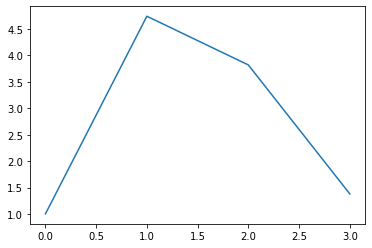

In [7]:
plt.plot(x)

We can also do an advanced visualization of the data

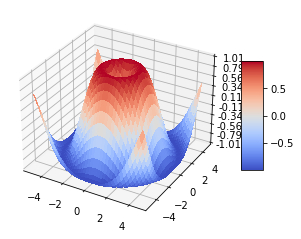

In [8]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

#import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make the mesh grid of some data for demonstration purposes
X1 = np.arange(-5, 5, 0.25)
X2 = np.arange(-5, 5, 0.25)
X1, X2 = np.meshgrid(X1, X2)
R = np.sqrt(X1**2 + X2**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X1, X2, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Or when it comes to performance analysis, we can plot our scaling data

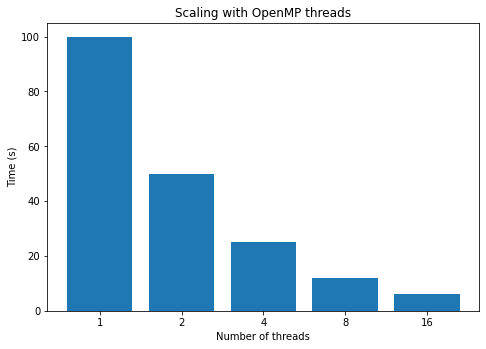

In [9]:
nthreads = ['1','2','4','8','16']
times = [100,50,25,12,6]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(nthreads,times)
ax.set_title('Scaling with OpenMP threads')
ax.set_ylabel('Time (s)')
ax.set_xlabel('Number of threads')
plt.show()